In [4]:
############################################################
# Лабораторная №12. НС прямого распространения – регрессия #
# Датасет: Concrete Compressive Strength                   #
# Автор: Кирилл                                            #
############################################################

# 1. Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


url = "https://raw.githubusercontent.com/chandanverma07/DataSets/master/Concrete_Data.csv"
df = pd.read_csv(url)


print(df.head())
print(df.describe())

   Cement  Blast  Fly Ash  Water  Superplasticizer      CA     FA  Age    CMS
0   540.0    0.0      0.0  162.0               2.5  1040.0  676.0   28  79.99
1   540.0    0.0      0.0  162.0               2.5  1055.0  676.0   28  61.89
2   332.5  142.5      0.0  228.0               0.0   932.0  594.0  270  40.27
3   332.5  142.5      0.0  228.0               0.0   932.0  594.0  365  41.05
4   198.6  132.4      0.0  192.0               0.0   978.4  825.5  360  44.30
            Cement        Blast      Fly Ash        Water  Superplasticizer  \
count  1030.000000  1030.000000  1030.000000  1030.000000       1030.000000   
mean    281.167864    73.895825    54.188350   181.567282          6.204660   
std     104.506364    86.279342    63.997004    21.354219          5.973841   
min     102.000000     0.000000     0.000000   121.800000          0.000000   
25%     192.375000     0.000000     0.000000   164.900000          0.000000   
50%     272.900000    22.000000     0.000000   185.000000 

In [6]:
# 3. Быстрый взгляд на данные и их колонки
df = pd.read_csv(url)
print(df.head())
print("Колонки:", df.columns.tolist())

# 4. Разделяем признаки и цель
target_col = 'CMS'                # <- здесь ваш целевой столбец
X = df.drop(target_col, axis=1).values
y = df[target_col].values


   Cement  Blast  Fly Ash  Water  Superplasticizer      CA     FA  Age    CMS
0   540.0    0.0      0.0  162.0               2.5  1040.0  676.0   28  79.99
1   540.0    0.0      0.0  162.0               2.5  1055.0  676.0   28  61.89
2   332.5  142.5      0.0  228.0               0.0   932.0  594.0  270  40.27
3   332.5  142.5      0.0  228.0               0.0   932.0  594.0  365  41.05
4   198.6  132.4      0.0  192.0               0.0   978.4  825.5  360  44.30
Колонки: ['Cement', 'Blast', 'Fly Ash', 'Water', 'Superplasticizer', 'CA', 'FA', 'Age', 'CMS']


In [9]:
# 5. Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 6. Масштабируем (важно для НС!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 7. Строим feed-forward сеть
model = Sequential(name="ConcreteMLP")
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,  activation='linear'))  # выход без активации

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=200, batch_size=32, verbose=0)

# 8. Оцениваем на тесте
y_pred = model.predict(X_test).ravel()
mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"MSE: {mse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MSE: 42.569 | MAE: 4.878 | R²: 0.835


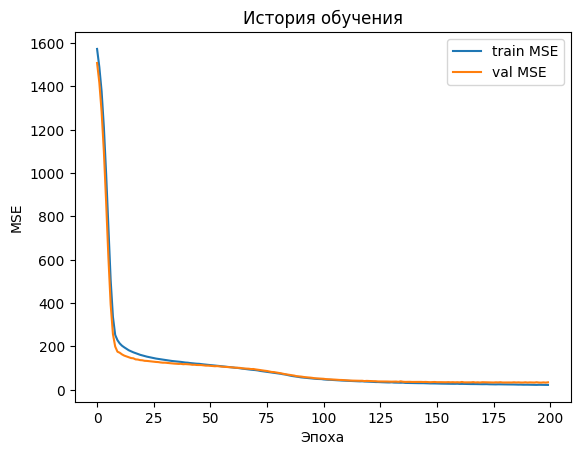

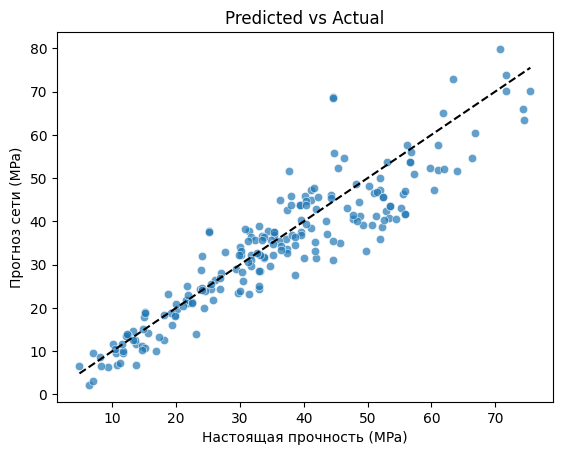

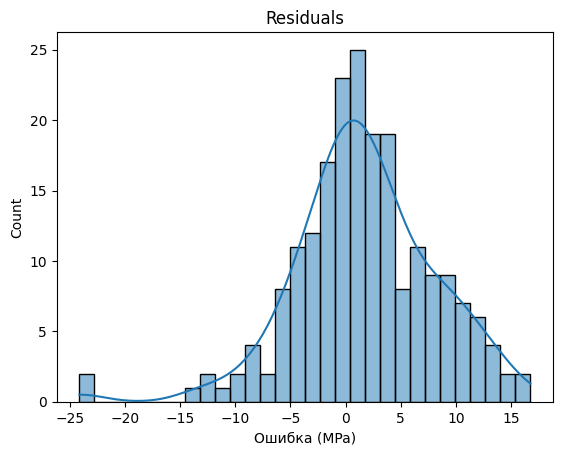

In [10]:



# 9. График обучения
plt.figure()
plt.plot(history.history['loss'], label='train MSE')
plt.plot(history.history['val_loss'], label='val MSE')
plt.xlabel('Эпоха'); plt.ylabel('MSE'); plt.legend(); plt.title('История обучения')
plt.show()

# 10. Диаграмма «факт vs прогноз»
plt.figure()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel('Настоящая прочность (MPa)')
plt.ylabel('Прогноз сети (MPa)')
plt.title('Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--')
plt.show()

# 11. Гистограмма остатков
plt.figure()
sns.histplot(y_test - y_pred, bins=30, kde=True)
plt.title('Residuals')
plt.xlabel('Ошибка (MPa)')
plt.show()

# 12. Обязательная Confusion Matrix (бинаризуем цену)
# делим прочность на 3 квантиля: low / mid / high
bins = np.quantile(y, [0, .33, .66, 1.0])
labels = ['Low', 'Mid', 'High']
y_test_cat = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)

# cm = confusion_matrix(y_test_cat, y_pred_cat, labels=labels)
# plt.figure()
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=labels, yticklabels=labels)
# plt.xlabel('Предсказано'); plt.ylabel('Истинно')
# plt.title('Квази-confusion matrix (классы = квантиля прочности)')
# plt.show()
